# Assignment I: Scraping, Twitter API & Pandas

---

>Konstantinos Kyrkos <br>
>Registration Number p3351907 <br>
>kkyrkos@aueb.gr

This notebook provides my solutions for the first assignment for the Practical Data Science class at Data Science MSc at AUEB. <br>
Bollow you will find the solution to the 3 exercises. <br>
The only prerequisite for running the commands below is to provide a config file named "twitter_config.py" which is used in order to connect and use the Twitter Api.

## Part 1: Scraping Twitter Accounts

### 1.1 Connect to Twitter

The following code will connect to the Tweeter api using the user credentials (provided they are present in a twitter_config.py file). <br>
Then the code will fetch the most trendy topics for Athens and print the first 10 of them.

In [2]:
import tweepy
import json

from twitter_config import config

auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

Athens_Code = 946738
 
Athens_Tweepy_Response = api.trends_place(Athens_Code)

resp = json.loads(json.dumps(Athens_Tweepy_Response, indent=1))

Athens_Trending_Topics = []

for trend in resp[0]["trends"]:
    Athens_Trending_Topics.append(trend["name"].strip("#"))

print(Athens_Trending_Topics[0:10])

['kalytera', '사랑한다_몬스타엑스', 'England', 'FosStoTounel', 'TheVoiceGR', 'OLYMTA', 'Mega', 'ΚΕΘΕΑ', 'καλο σαββατοκυριακο', 'Γιαννα']


### 1.2 Username Scraping

The following code will scrape all 49 best Twitter accounts to follow in UK politics from the link given and put them in a list

In [3]:
import requests
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

driver=webdriver.Firefox(options = options)
driver.get("https://www.businessinsider.com/uk-politics-twitter-accounts-2016-8?r=US&IR=T")   

soup = BeautifulSoup(driver.page_source, 'html.parser')
slides = soup.findAll("div",{"class":"slide"})

linkPattern = '(\@.*?\<)'
validLinkPattern = '(.*?[<].*)'
famousUsernames = []

for slide in slides:    
    link = slide.findAll('a', {'target':'_blank'})    
    strLink = str(link)
    if re.match(validLinkPattern, strLink):
        username = re.findall(linkPattern, strLink)[0]
        famousUsernames.append(username.strip('<'))
    

driver.close()

print(famousUsernames)

['@Tom_Slater_', '@MattSingh_', '@asabenn', '@robfordmancs', '@LadPolitics', '@samgadjones', '@PaulbernalUK', '@youngvulgarian', '@JolyonMaugham', '@IanDunt', '@BethRigby', '@PatrickStrud', '@NadineDorriesMP', '@jreedmp', '@stephenkb', '@AbiWilks', '@jessphillips\xa0', '@SamCoatesTimes', '@toadmeister', '@jimwaterson', '@RuthDavidsonMSP', '@DavidAllenGreen', '@JuliaHB1', '@DavidLammy', '@DPJHodges', '@ShippersUnbound', '@JamieRoss7', '@DouglasCarswell', '@SophyRidgeSky', '@sunny_hundal', '@MrHarryCole', '@MichaelLCrick', '@JohnRentoul', '@stellacreasy', '@GuidoFawkes', '@tom_watson\xa0', '@faisalislam\xa0', '@paulmasonnews\xa0', '@OwenJones84', '@suttonnick', '@afneil', '@paulwaugh']


### 1.3 Fetch Tweets

Now the code below wil fetch the tweets posted in the last 24 hours for each of the usernames we gathered in the previous excercise. <br>
We use try/except to bypass if one of the users does not have an account or any other issue occurs and we return a suitable message. <br>
We also use DateTime and timedelta, to define the desired time period for the fetched tweets. <br>
A tweepy.Cursor is used, who fetches 100 tweets at a time and api.user_timeline is also used in order to fetch the tweets. <br>
Finally the number of tweets that are fetched for each username is printed along with the username.

In [179]:
from datetime import datetime, timedelta      

for un in famousUsernames:
    count = 0
    try:
        for tweet in tweepy.Cursor(api.user_timeline, screen_name=un, include_rts=False).items(100):
             if (datetime.now() - tweet.created_at ).days < 1:
                count = count +1
    except Exception as ex:
        print("Cound not fetch ", un)        
    print("User: ",un," Tweet count is: ",count)        


User:  @Tom_Slater_  Tweet count is:  0
User:  @MattSingh_  Tweet count is:  24
User:  @asabenn  Tweet count is:  2
User:  @robfordmancs  Tweet count is:  22
User:  @LadPolitics  Tweet count is:  8
User:  @samgadjones  Tweet count is:  3
User:  @PaulbernalUK  Tweet count is:  100
User:  @youngvulgarian  Tweet count is:  24
User:  @JolyonMaugham  Tweet count is:  39
User:  @IanDunt  Tweet count is:  7
User:  @BethRigby  Tweet count is:  10
User:  @PatrickStrud  Tweet count is:  0
Cound not fetch  @NadineDorriesMP
User:  @NadineDorriesMP  Tweet count is:  0
Cound not fetch  @jreedmp
User:  @jreedmp  Tweet count is:  0
User:  @stephenkb  Tweet count is:  38
User:  @AbiWilks  Tweet count is:  19
Cound not fetch  @jessphillips 
User:  @jessphillips   Tweet count is:  0
User:  @SamCoatesTimes  Tweet count is:  0
User:  @toadmeister  Tweet count is:  4
User:  @jimwaterson  Tweet count is:  20
User:  @RuthDavidsonMSP  Tweet count is:  3
User:  @DavidAllenGreen  Tweet count is:  1
User:  @Julia

## Part 2: Processing Twitter accounts

### 2.1 Scrape and Put in a DataFrame

The code bellow will scrape the Twitter accounts of all the UK parliament members from the given link and then (after some processing) put them in a DataFrame whose columns are named 'name', 'username', 'constituency', 'party' and 'num_followers'.<br>
When the Dataframe is ready, we print the result to have a clear view of the outcome.

In [4]:
import numpy as np
import pandas as pd
    
driver = webdriver.Firefox(options = options)
driver.get("https://www.mpsontwitter.co.uk/list")   
soup = BeautifulSoup(driver.page_source, 'html.parser')
body = soup.find("tbody",{"id":"mp_wrapper"})
rows = body.findAll("tr")
df = pd.DataFrame(columns=['name', 'username', 'constituency', 'party', 'num_followers'])
row_marker = 0

for row in rows:
    columns = row.findAll("td")
    col = 0
    name = ""
    username = ""
    constituency = ""
    party = ""
    num_followers = 0
    for column in columns:
        if col == 2:
            name = column.get_text()
        
        if col == 4:
            constituency = column.get_text()
            
        if col == 6:
            num_followers = int(column.get_text().replace(',',''))
            
        if col == 8:
            username = column.findNext('a')['href'].split('/')[3]   
                
        if col == 9:
            words = column['class']
            for word in words:
                party = party + word + " "
            
        col +=1
    df.loc[row_marker] = [name, username,  constituency, party, num_followers]
    row_marker +=1

df.num_followers = df.num_followers.astype(int)
print(df)

driver.close()

                 name          username          constituency  \
0       Adam Afriyie       @AdamAfriyie               Windsor   
1        Alan Duncan      @AlanDuncanMP    Rutland and Melton   
2           Alan Mak         @AlanMakMP                Havant   
3      Alberto Costa    @AlbertoCostaMP  South Leicestershire   
4    Alec Shelbrooke    @AlecShelbrooke    Elmet and Rothwell   
..                ...               ...                   ...   
582       Ann Coffey      @anncoffey_mp             Stockport   
583       Anna Soubry      @Anna_Soubry              Broxtowe   
584     Chris Leslie     @ChrisLeslieMP       Nottingham East   
585        Joan Ryan   @joanryanEnfield         Enfield North   
586       Mike Gapes         @MikeGapes          Ilford South   

                      party  num_followers  
0             Conservative           14965  
1             Conservative           26116  
2             Conservative            8346  
3             Conservative            8

### 2.2 Create a Hierarchical Index

Now we create a hierarchical index where the party is the top level and followers_num is next and then we display only the username column.

In [5]:
df.set_index(['party', 'num_followers']).username
print(df.username)

0          @AdamAfriyie
1         @AlanDuncanMP
2            @AlanMakMP
3       @AlbertoCostaMP
4       @AlecShelbrooke
             ...       
582       @anncoffey_mp
583        @Anna_Soubry
584      @ChrisLeslieMP
585    @joanryanEnfield
586          @MikeGapes
Name: username, Length: 587, dtype: object


### 2.3 Assess the Party Tweeter Power

In order to assess the Party Tweeter Power, first we use plot from matplotlib and draw a scatterplot with the values of each party member represented with a mark on the plot. Each party will have a different colour and we will also use alpha in the chart in order to assess the points where multiple values are present.

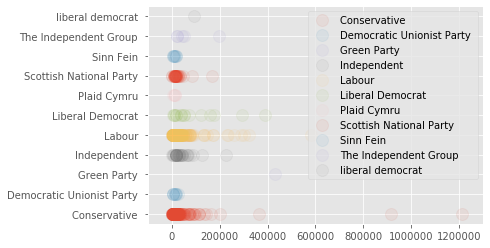

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

grouped = df.groupby('party')

fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in grouped:
    ax.plot(group.num_followers, group.party, marker='o', linestyle='', ms=12, label=name, alpha =.07)
ax.legend()
plt.xlim(-100000, 1300000)
plt.show()


We can see from the graph above that the Conservative and the Labour party have the most members and these members have between 0 and 200000 followers each in general.

At this point we can also use a bar chart in order to have a better image of the power of each Party in Tweeter.

                         party num_followers
0                Conservative        7619174
1   Democratic Unionist Party          98092
2                 Green Party         431957
3                 Independent        1254708
4                      Labour       10874073
5            Liberal Democrat        1448784
6                 Plaid Cymru          38827
7     Scottish National Party         787629
8                   Sinn Fein          69685
9       The Independent Group         332976
10           liberal democrat          92265


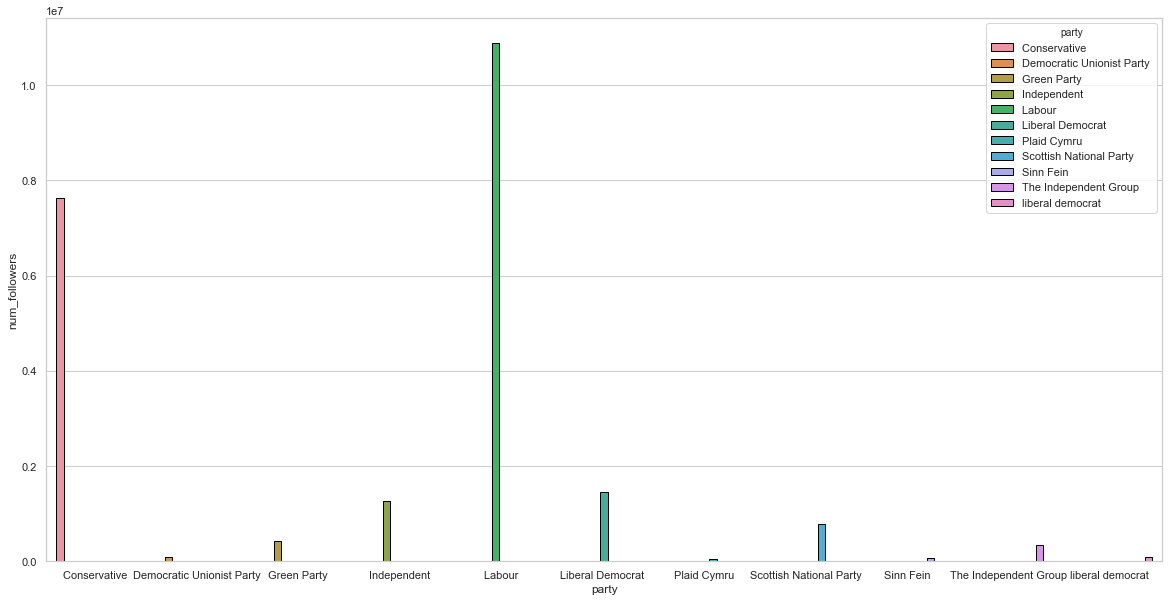

In [7]:
import scipy as sp
import seaborn as sns

seaborn_df = pd.DataFrame(columns=['party', 'num_followers'])

count = 0  
for name, group in grouped:
    seaborn_df = seaborn_df.append({'party':name, 'num_followers':group.num_followers.sum()},ignore_index=True)
    
print(seaborn_df)
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='party', y='num_followers', 
                 hue=seaborn_df.party,
                 edgecolor='black',
                 data=seaborn_df)


## Part 3: Processing Text Content

### 3.1 Prepare a Profanity Set

At first we use the text found in the link provided in order to create a list of abusive words. <br>
Next we discard any possible noise found in the data.

In [9]:
driver = webdriver.Firefox(options = options)
driver.get("http://staffwww.dcs.shef.ac.uk/people/G.Gorrell/publications-materials/abuse-terms.txt")   
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.close()

At this after we have the data we want and now we split the rows found in order to get the words, remove possible noise and then put the values in a list in order to use them later. <br>
Then we print the first 10 of them in order to evaluate our results until this point.

In [10]:
rows = soup.find('pre').text.split('***********************************')[1]
rows = (rows.split('\n'))
rows_size = len(rows)
rows = rows[2:rows_size-4]

bad_words = []
for row in rows:
    articleWord = row.split(' ')
    if len(articleWord)==2:
        if articleWord[0]=="a" or articleWord[0]=="the":
            bad_words.append(articleWord[1])
    else:
        bad_words.append(row)        

print(bad_words[0:10])

['cock', 'anus', 'arsebandit', 'arsehole', 'ass-hat', 'ass-jabber', 'ass-pirate', 'assbag', 'assbandit', 'assbite']


### 3.2 Parse Tweets

Now we read tweets from the given link and rename the tweet column to "text".

In [11]:
import io

url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
s = requests.get(url).content
offensive_tweets = pd.read_csv(io.StringIO(s.decode('utf-8')))
offensive_tweets.columns.values[6]='text'

The following code creates a new column with the list of words of each text row. <br>
Then the first 5 rows of the dataframe are displayed in order to have a clear view of the progress so far.

In [12]:
offensive_tweets['words'] = offensive_tweets.text.str.split(' ')

offensive_tweets.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,text,words
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[!!!, RT, @mayasolovely:, As, a, woman, you, s..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[!!!!!, RT, @mleew17:, boy, dats, cold...tyga,..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[!!!!!!!, RT, @UrKindOfBrand, Dawg!!!!, RT, @8..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[!!!!!!!!!, RT, @C_G_Anderson:, @viva_based, s..."
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[!!!!!!!!!!!!!, RT, @ShenikaRoberts:, The, shi..."


### 3.3 Count Abuse

Bellow we use the bad_words set created in 3.1 to detect bad words in the word list of each tweet fetched in the last step. <br>
We save the number of bad words found in each list in a new column and also keep the abuse words in another column for future use. <br>
We also print the first 10 rows of the dataframe in order to have a view of the process so far. <br>
Finally we find the mean, median, minimum, maximum, and sum of bad words in each class.

In [13]:
offensive_tweets["counter"] = 0
offensive_tweets["abusive_words"] = np.empty((len(offensive_tweets), 0)).tolist()

offTweets = offensive_tweets

for index, row in offensive_tweets.iterrows():
    c = 0
    for word in row.words:
        if word in bad_words:            
            c = c + 1
            offTweets.loc[index,'abusive_words'].append(word)
            
    if c>0:
        offTweets.loc[index,'counter'] = c

print(offTweets.head(10))

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   
5           5      3            1                   2        0      1   
6           6      3            0                   3        0      1   
7           7      3            0                   3        0      1   
8           8      3            0                   3        0      1   
9           9      3            1                   2        0      1   

                                                text  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand

Below we first map the current values of column 'class' to more descriptive values and then print the first 5 rows of the dataframe in order to see the result. <br>
Then we calculate the mean for each class.

In [14]:
offTweets['class'] = offTweets['class'].map({0: 'hate', 1: 'offensive', 2: 'neither'})
print(offTweets.head())
groupedOffTweets = offTweets.groupby('class')
offTweetsCountMean = groupedOffTweets['counter'].mean()
print(" ")
print("-------------------------------------------------")
print("The mean values for each class are:")
print(offTweetsCountMean)

   Unnamed: 0  count  hate_speech  offensive_language  neither      class  \
0           0      3            0                   0        3    neither   
1           1      3            0                   3        0  offensive   
2           2      3            0                   3        0  offensive   
3           3      3            0                   2        1  offensive   
4           4      6            0                   6        0  offensive   

                                                text  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                               words  counter abusive_words  
0  [!!!, RT, @mayasolovely:, As, a, woman, you, s...        0            []  
1  [!!!!!, RT, @mleew17:, boy, dats, cold...

Next we calculate the median for each class.

In [15]:
offTweetsCountMedian = groupedOffTweets['counter'].median()
print("The median values for each class are:")
print(offTweetsCountMedian)

The median values for each class are:
class
hate         1
neither      0
offensive    1
Name: counter, dtype: int64


Next we do the same for the max and the min values of each class

In [16]:
offTweetsCountMax = groupedOffTweets['counter'].max()
print("The max values for each class are:")
print(offTweetsCountMax)
print('-----------------------------------')
offTweetsCountMin = groupedOffTweets['counter'].min()
print("The min values for each class are:")
print(offTweetsCountMin)

The max values for each class are:
class
hate         11
neither       2
offensive    14
Name: counter, dtype: int64
-----------------------------------
The min values for each class are:
class
hate         0
neither      0
offensive    0
Name: counter, dtype: int64


Finally we calculate and print the sum of each class.

In [17]:
offTweetsCountSums = groupedOffTweets['counter'].sum()
print("The sums of values for each class are:")
print(offTweetsCountSums)

The sums of values for each class are:
class
hate           961
neither        156
offensive    13011
Name: counter, dtype: int64


### 3.4 Visualize Profanity

At this point we create multiple plots presenting bad words per class. <br>
Below we start by creating a boxplot using seaborn.

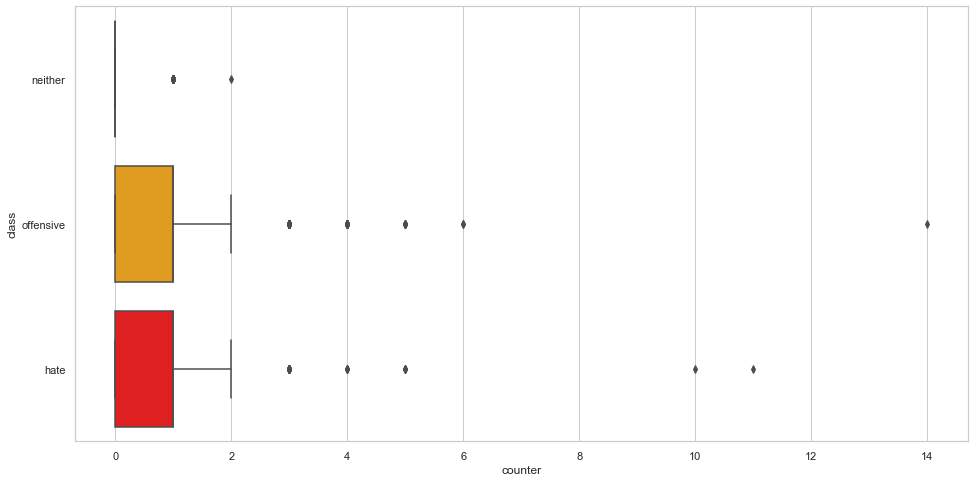

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x=offTweets['counter'],
                 y=offTweets['class'],
                 palette={'hate' : 'red' , 'offensive': 'orange' , 'neither': 'yellow'})

Next we use seaborns stripplot to show all the points for each class and set the alpha to 0.5 in order to display clearly where multiple points are present.

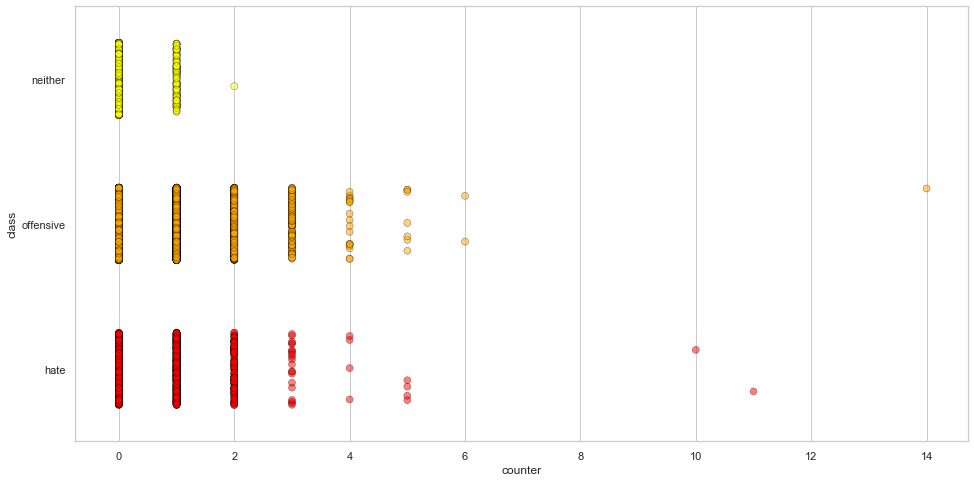

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
ax = sns.stripplot(x=offTweets['counter'],
                y=offTweets['class'],
                linewidth=0.5,
                size=7,
                jitter=.25,
                edgecolor='black',
                alpha = 0.5,
                palette={'hate' : 'red' , 'offensive': 'orange' , 'neither': 'yellow'})


Next we try seaborn's violin plot to present the values.

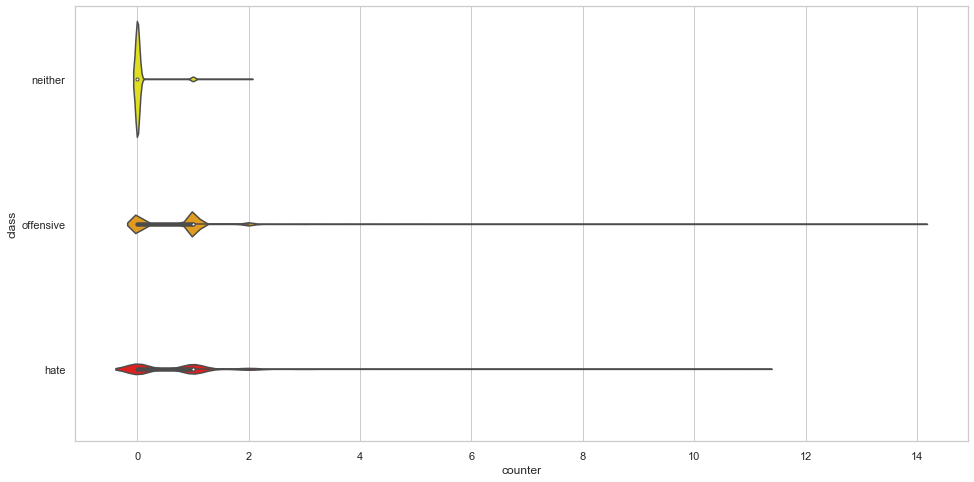

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
ax = sns.violinplot(x=offTweets['counter'],
                    y=offTweets['class'],
                    edgecolor='black',
                    palette={'hate' : 'red' , 'offensive': 'orange' , 'neither': 'yellow'})

Finally we again to present the bad words per class we use seaborn's distplot.

Starting with class 0 (hate speech) we get:

Text(0, 0.5, 'Bad words')

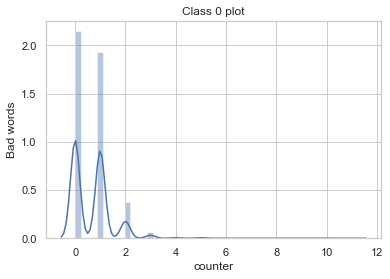

In [21]:
hate = offTweets.loc[offTweets['class']=='hate']
sns.set(style="whitegrid")
ax = sns.distplot(hate['counter'])
ax.set_title('Class 0 plot')
ax.set_ylabel('Bad words')

Moving on the class 1 (offensive) we get:

Text(0, 0.5, 'Bad words')

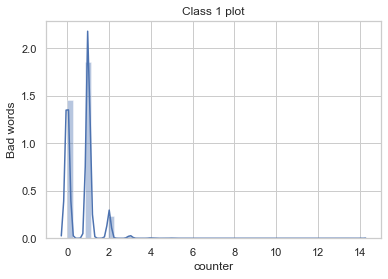

In [22]:
offensive = offTweets.loc[offTweets['class']=='offensive']
sns.set(style="whitegrid")
ax = sns.distplot(offensive['counter'])
ax.set_title('Class 1 plot')
ax.set_ylabel('Bad words')

At last, for class 2 (neither of the two above) we get:

Text(0, 0.5, 'Bad words')

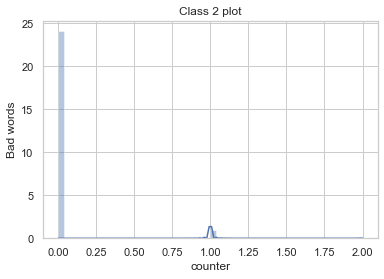

In [23]:
neither = offTweets.loc[offTweets['class']=='neither']
sns.set(style="whitegrid")
ax = sns.distplot(neither['counter'])
ax.set_title('Class 2 plot')
ax.set_ylabel('Bad words')

Summarizing all the graphs above we can cleary see that, the category with the least bad words is class 2 which has most of it's values in 0 and only some of the tweets contain barely one bad word. <br>
Next what we can also comment about the results of class 1 and 0. <br>
These two classes have both more bad words than class 2 in general. <br>
Also we can see that Class 1 (offensive tweets) has more values in the (1,2) range than class 0 (hate speech), but class 0 has more values in the range (2,14) meaning that is more likely for the tweets belonging to this class to have more offensive words than class 1 tweets.

### 3.5 Explore Profanity per Class

Finally we will explore the profanity per class, finding the top 30 abuse terms per class using Counter from Python's collections library.

In [24]:
from collections import Counter

cnt = Counter()

print("Class 0 (hate speech), 30 most common abuse terms are:")
hate_words = []
for words in hate['abusive_words']:
    for word in words:
        hate_words.append(word)
    
print(Counter(hate_words).most_common(30))
print("-------------------------------------------------------------")

offensive_words = []
for words in offensive['abusive_words']:
    for word in words:
        offensive_words.append(word)

print("Class 1 (offensive tweets), 30 most common abuse terms are:")
print(Counter(offensive_words).most_common(30))
print("-------------------------------------------------------------")

neither_words = []
for words in neither['abusive_words']:
    for word in words:
        neither_words.append(word)

print("Class 2 (neither of the 2 categories above), 30 most common abuse terms are:")
print(Counter(neither_words).most_common(30))

Class 0 (hate speech), 30 most common abuse terms are:
[('bitch', 163), ('faggot', 148), ('nigga', 103), ('nigger', 82), ('fag', 57), ('bitches', 51), ('pussy', 38), ('niggers', 36), ('kill', 30), ('dyke', 25), ('queer', 23), ('cunt', 18), ('coon', 18), ('retard', 15), ('spic', 15), ('dick', 14), ('die', 10), ('beaner', 8), ('whore', 6), ('gook', 6), ('wetback', 5), ('negro', 5), ('hang', 5), ('chink', 5), ('tranny', 5), ('homo', 4), ('rape', 4), ('asshole', 3), ('slut', 3), ('cock', 3)]
-------------------------------------------------------------
Class 1 (offensive tweets), 30 most common abuse terms are:
[('bitch', 6431), ('bitches', 2520), ('pussy', 1658), ('nigga', 861), ('dick', 245), ('faggot', 179), ('cunt', 152), ('fag', 108), ('nigger', 99), ('kill', 81), ('pussies', 64), ('retard', 57), ('dyke', 40), ('die', 37), ('queer', 33), ('niggers', 26), ('twat', 24), ('hang', 23), ('negro', 22), ('tranny', 19), ('balls', 19), ('slut', 18), ('whore', 18), ('cock', 18), ('coon', 14), (